# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Webscraping Project 4 Lab

Week 4 | Day 4

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com (or other sites at your team's discretion). In the second part, the focus is on using listings with salary information to build a model and predict high or low salaries and what features are predictive of that result.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver

import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

path_phantom = '//Applications/phantomjs'

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from wordcloud import WordCloud, ImageColorGenerator, get_single_color_func

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above
- Include any other features you may want to use later (e.g. summary, #of reviews...)

In [3]:
## YOUR CODE HERE
def extract_location_from_result(result):
    try:
        location = result.find('span', class_='location').text.strip()
    except:
        location = ''
    return location

def extract_title_from_result(result):
    try:
        job_title = result.find('a', class_='jobtitle').text.strip('\n')
    except:
        try:
            job_title = result.find('h2', class_='jobtitle').text.strip('\n')
        except:
            job_title = ''
    return job_title

def extract_summary_from_result(result):
    try:
        summary = result.find('span', class_='summary').text.strip()
    except:
        summary = ''
    return summary

def extract_company_from_result(result):
    try:
        company = result.find('span', class_='company').text.strip()
    except:
        company = ''
    return company

def extract_reviews_from_result(result):
    try:
        sub = result.find('span', class_='slNoUnderline').text.strip()
        if 'review' in sub:
            reviews = sub.split()[0]
    except:
        reviews = ''
    return reviews

def extract_salary_from_result(result):
    try:
        salary = result.find('td', class_='snip').find('nobr').text.strip()
#         salary_text = salary_text.split()
#         salary = float(salary_text[0].strip('$').replace(',',''))
    except:
        salary = ''
    return salary

def get_all_details(result):
#     if extract_salary_from_result(result) != '':
    return [extract_title_from_result(result),\
            extract_company_from_result(result),\
            extract_location_from_result(result),\
            extract_summary_from_result(result),\
            extract_salary_from_result(result)]
#     else:
#         return 'skip'

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Indeed.com only has salary information for an estimated 20% of job postings. You may want to add other cities to the list below to gather more data. 
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [16]:
cities = open('data/City_List.txt', 'r')
city_list = cities.readlines()
cities.close()
city_list = [i.strip(',\r\n') for i in city_list]
city_list = [i.strip() for i in city_list]
city_list = [i.strip("'") for i in city_list]
city_list = [i.split(',') for i in city_list]
# city_list = [i[0:-1] for i in city_list]
city_state_list = [[i[0] if len(i[0:-1]) == 1 else '+'.join([x.strip() for x in i]),i[-1]] for i in city_list]
city_state_list[:5]

[['Akron', ' OH'],
 ['Albany', ' GA'],
 ['Albany', ' NY'],
 ['Alexandria', ' LA'],
 ['Amarillo', ' TX']]

In [19]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}%2C+{}&start={}"
max_results_per_city = 100
results = []

In [20]:
## YOUR CODE HERE
driver = webdriver.PhantomJS(executable_path=path_phantom)

In [21]:
for city in city_state_list:
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        full_url = url_template.format(city[0], city[1],  start)
        driver.get(full_url)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        # Append to the full set of results
        for item in soup.findAll('div', class_='result'):
            out = get_all_details(item)
            out.extend([city[0], city[1]])
            results.append(out)
#         pass

KeyboardInterrupt: 

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [8]:
df = pd.DataFrame(results, columns=['title', 'company', 'location', 'summary', 'salary', 'search_city'])

In [9]:
df.shape

(31376, 6)

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [10]:
df['rate'] = df['salary'].map(lambda x: (40*50) if 'hour' in x else 12 if 'month' in x else 1)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [11]:
## YOUR CODE HERE
def get_salary_amount(salary_string):
    try:
        #print salary_string
        salary_string.replace('-', ' ')
        sal_list = salary_string.split()
        #print sal_list
        figures = []
        for i in sal_list:
            try:
#                 print i.strip('$')
                if 'k' in i:
                    num = float(i.strip('$').strip('k').replace(',','')) * 1000
                else:
                    num = float(i.strip('$').strip('k').replace(',',''))
                figures.append(num)
            except:
                pass
#         print figures
        return (np.mean(figures))
    except:
        return np.nan

In [12]:
df['est_sal_per_unit_time'] = df['salary'].map(get_salary_amount)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [13]:
df['est_annual_sal'] = df['est_sal_per_unit_time']*df['rate']

In [14]:
df.head()

,title,company,location,summary,salary,search_city,rate,est_sal_per_unit_time,est_annual_sal
0,"Software Development Engineer, Data Science- R...","Audible, Inc.",United States,Do you enjoy working with Data Scientists to w...,,Roanoke,1,NaN,NaN
1,"Software Development Engineer, Big Data Analyt...",Amazon Corporate LLC,United States,We specifically seek candidates who want to jo...,,Roanoke,1,NaN,NaN
2,Principal Research Scientist- Relocation Oppor...,Amazon Corporate LLC,United States,Experience with very large-scale data and the ...,,Roanoke,1,NaN,NaN
3,Applications/Product Development Engineer/Scie...,"Lohmann Specialty Coatings, LLC (Orange, VA)","Roanoke, VA","Ability to conduct routine lab tests, analyze ...",,Roanoke,1,NaN,NaN
4,"Software Development Engineer, Big Data- Reloc...",Amazon Corporate LLC,United States,Are you interested in building data pipelines ...,,Roanoke,1,NaN,NaN


In [40]:
df.describe()

,rate,est_sal_per_unit_time,est_annual_sal
count,31579.000000,1232.000000,1232.000000
mean,18.275500,51271.862776,68102.034903
std,184.721686,48925.967728,38550.693975
min,1.000000,10.000000,500.000000
25%,1.000000,2915.500000,41300.000000
50%,1.000000,52000.000000,59000.000000
75%,1.000000,85000.000000,88082.750000
max,2000.000000,250000.000000,300000.000000


In [41]:
df[df['est_annual_sal'].notnull()]

,title,company,location,summary,salary,rate,est_sal_per_unit_time,est_annual_sal
137,Research Scientist II,Health Research Incorporated,"Albany, NY",And approve validation data. Strong written an...,"$66,244 a year",1,66244.0,66244.0
140,Research Scientist 1 (Epidemiology) - 07090,"Health, Department of","Albany, NY","The Research Scientist 1 (Epidemiology), G-18 ...","$53,339 - $67,827 a year",1,60583.0,60583.0
144,Assistant Research Scientist,Health Research Incorporated,"Albany, NY",Prepare and compile data reports and summaries...,"$43,264 a year",1,43264.0,43264.0
193,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
204,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
215,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
226,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
237,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
248,Senior Process Engineer - Food Industry,3coast,"Albany, NY",?Work closely with other specialists (includin...,"$75,000 - $120,000 a year",1,97500.0,97500.0
377,Data scientist,Even,"Oakland, CA",Collaborate with our engineers on our internal...,"$34,142 a year",1,34142.0,34142.0


### Save your results as a CSV

In [42]:
df2 = df.copy()
df2 = df2.drop(['salary', 'rate', 'est_sal_per_unit_time'], axis=1)

In [5]:
df2 = pd.read_csv('indeed.csv')

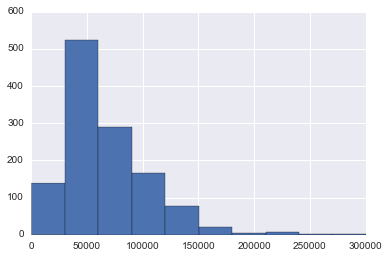

In [44]:
df2.est_annual_sal.hist() 

In [9]:
vectorizer = CountVectorizer(ngram_range=(1,5),\
                            stop_words='english',\
                            max_features=1000,\
                            binary=True)

In [10]:
vectorizer.fit(df2['summary'])

CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
summary_features = vectorizer.transform(df2['summary'])

In [12]:
summary_features

<244x1000 sparse matrix of type '<type 'numpy.int64'>'
	with 7784 stored elements in Compressed Sparse Row format>

In [13]:
df2['high_sal'] = df2['est_annual_sal'].map(lambda x: 1 if x > df2['est_annual_sal'].median() else 0)

In [14]:
y = df2['high_sal']

In [15]:
df2['sal_range'] = df2['est_annual_sal'].map(lambda x: 2 if x >\
                                             df2['est_annual_sal'].median()+2*df2['est_annual_sal'].std() else\
                                            1 if x > df2['est_annual_sal'].median()-df2['est_annual_sal'].std()\
                                            else 0)

In [16]:
df2.head()

,Unnamed: 0,title,company,location,summary,est_annual_sal,high_sal,sal_range
0,0,Machine Learning Engineer,Workbridge Associates,"San Francisco, CA",This person will be working alongside the Data...,135000.0,1,1
1,1,Senior Data Scientist,Workbridge Associates,"San Francisco, CA",A leading healthcare start up is looking to br...,165000.0,1,1
2,2,"Data Science Resident (DSR), and gU Resident",Galvanize,"San Francisco, CA","As part of the Residency program, you will rec...",1250.0,0,0
3,3,Lead Data Scientist (Life Sciences),Workbridge Associates,"San Francisco, CA",A leading technology company is looking for Da...,165000.0,1,1
4,4,Associate Scientist,Hart,"South San Francisco, CA",Communicates data and interpretation to work g...,60000.0,0,1


In [20]:
y = df2['sal_range']
logreg = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
model = logreg.fit(summary_features, y)
predicted = model.predict(summary_features)

In [21]:
results = pd.DataFrame([y,predicted], index = ['actual', 'predicted']).T

In [22]:
results['match'] = results['actual'] == results['predicted']

In [23]:
model.score(summary_features, y)

1.0

In [24]:
model.get_params

<bound method LogisticRegressionCV.get_params of LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)>

In [26]:
feature_imp = pd.DataFrame([vectorizer.get_feature_names(), model.coef_.tolist()[0]], index=['features', 'coef']).T

feature_imp.sort_values(by='coef', ascending=False).head()

,features,coef
549,managing,2.94407
813,responsible,2.22959
286,development data,1.62624
361,faculty,1.1066
722,program,1.09317


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
tv = TfidfVectorizer(ngram_range=(1,5),\
                            stop_words='english',\
                            max_features=1000,\
                            binary=True)

In [29]:
X2 = tv.fit_transform(df2['summary'])

In [30]:
logreg2 = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
model2 = logreg2.fit(X2, y)
predicted = model.predict(X2)

In [31]:
model2.score(X2, y)

1.0

In [32]:
feature_imp2 = pd.DataFrame([tv.get_feature_names(), model2.coef_.tolist()[0]], index=['features', 'coef']).T

feature_imp2.sort_values(by='coef', ascending=False).head()

,features,coef
549,managing,5.77044
286,development data,4.9468
813,responsible,4.1983
739,provider,3.30627
378,fortune,3.18399


In [33]:
from sklearn.cross_validation import train_test_split

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(summary_features,y,test_size=0.2, stratify=y)

In [35]:
lr2 = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='lbfgs')
m2 = lr2.fit(X_train, y_train)

//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [36]:
p2 = m2.predict_proba(X_test)

In [37]:
check = pd.DataFrame(p2, columns=['p_low', 'p_medium','p_high'])

In [38]:
m2.score(X_test, y_test)

0.83673469387755106

In [39]:
check['actual'] = np.array(y_test)

In [40]:
check.head()

,p_low,p_medium,p_high,actual
0,0.005982,0.503067,0.490950,2
1,0.055910,0.744166,0.199923,1
2,0.000160,0.999704,0.000136,1
3,0.010816,0.984549,0.004635,1
4,0.011587,0.945388,0.043025,1


In [41]:
check['p_high_2'] = check['p_high'].map(lambda x: 1 if x > 0.5 else 0)

In [42]:
check.head(10)

,p_low,p_medium,p_high,actual,p_high_2
0,0.005982,0.503067,0.490950,2,0
1,0.055910,0.744166,0.199923,1,0
2,0.000160,0.999704,0.000136,1,0
3,0.010816,0.984549,0.004635,1,0
4,0.011587,0.945388,0.043025,1,0
5,0.000160,0.999704,0.000136,1,0
6,0.201530,0.762418,0.036052,1,0
7,0.017351,0.970077,0.012572,1,0
8,0.001616,0.960459,0.037925,1,0
9,0.019326,0.940742,0.039932,2,0


In [43]:
check['p'] = m2.predict(X_test)

In [45]:
len(check)

49

In [46]:
tv2 = TfidfVectorizer(ngram_range=(1,5),\
                            stop_words='english',\
                            max_features=150,\
                            binary=True)
tv2.fit(df2['summary'])
test = tv2.get_feature_names()

(-0.5, 399.5, 199.5, -0.5)

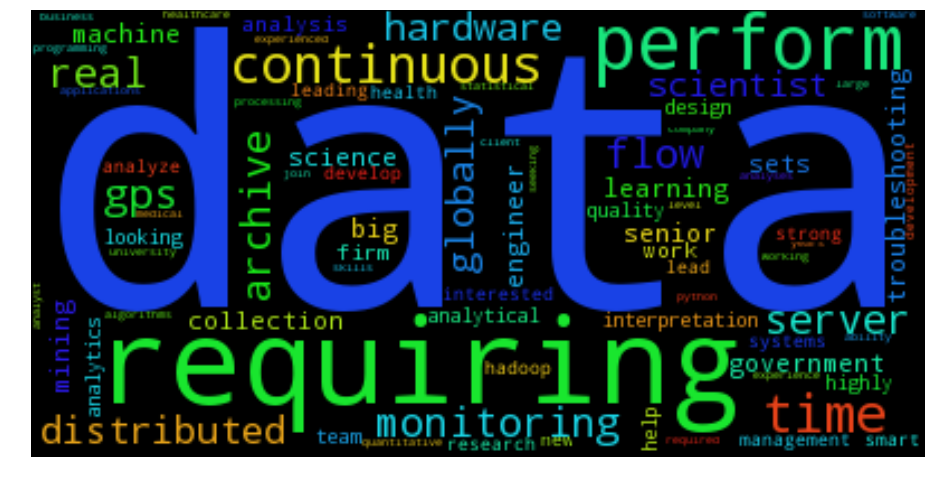

In [51]:
wordcloud = WordCloud().generate(' '.join(test))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")

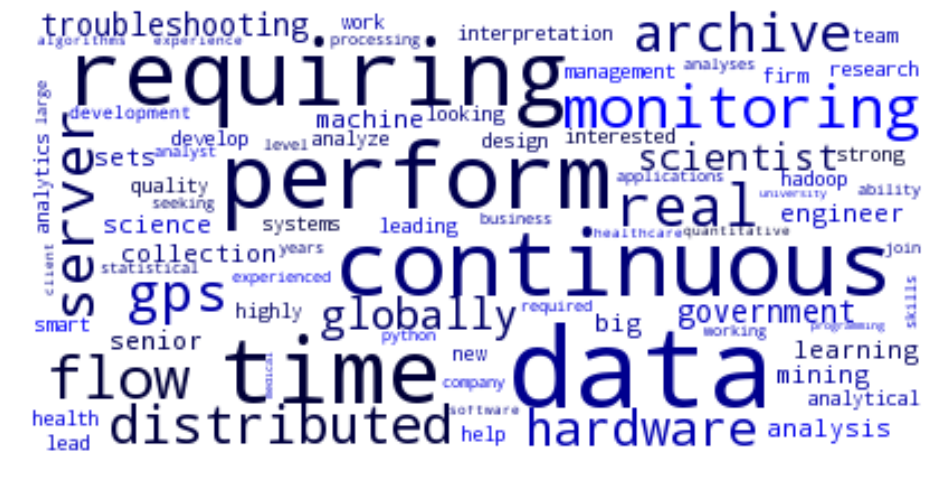

In [53]:
wordcloud = WordCloud(max_font_size=50, relative_scaling=0.3, background_color='white',\
                      color_func=get_single_color_func('blue')).generate(' '.join(test))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [54]:
# importing csvs

In [55]:
amex = pd.read_csv('AMEX.csv')

In [56]:
amex.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
0,XXII,"22nd Century Group, Inc",1.26,$103.57M,n/a,Consumer Non-Durables,Farming/Seeds/Milling,http://www.nasdaq.com/symbol/xxii
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,4.95,$1.27B,1986,n/a,n/a,http://www.nasdaq.com/symbol/fax
2,IAF,Aberdeen Australia Equity Fund Inc,5.64,$128.42M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/iaf
3,CH,"Aberdeen Chile Fund, Inc.",6.23,$58.48M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/ch
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,12.39,$119.92M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/abe


In [57]:
amex2 = amex.drop(amex[amex.MarketCap=='n/a'].index)

In [58]:
amex2.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
0,XXII,"22nd Century Group, Inc",1.26,$103.57M,n/a,Consumer Non-Durables,Farming/Seeds/Milling,http://www.nasdaq.com/symbol/xxii
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,4.95,$1.27B,1986,n/a,n/a,http://www.nasdaq.com/symbol/fax
2,IAF,Aberdeen Australia Equity Fund Inc,5.64,$128.42M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/iaf
3,CH,"Aberdeen Chile Fund, Inc.",6.23,$58.48M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/ch
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,12.39,$119.92M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/abe


In [59]:
living_index = pd.read_csv('Living_Index.csv')
living_index.head()

,Urban Area,100% Composite Index,13 % Grocery Items,29 % Housing,10% Utilities,12 % Transportation,4% Health Care,32 % Miscellaneous Goods and Services
0,"Anniston-Calhoun, County, AL",91.2,101.2,74.8,111.2,88.8,89.3,96.6
1,Akron OH,100.2,105.1,99.7,107.9,107.1,86.8,96.0
2,"Albany, GA",90.1,108.7,74.8,82.0,96.6,89.8,96.8
3,"Albany, NY",108.1,105.0,112.6,101.0,102.8,111.7,108.6
4,"Alexandria, LA",95.1,96.0,92.7,89.9,97.2,92.9,98.2


In [60]:
nyse = pd.read_csv('NYSE.csv')
nyse.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
0,AFL,Aflac Incorporated,70.96,$29.06B,n/a,Finance,Accident &Health Insurance,http://www.nasdaq.com/symbol/afl
1,AFSD,Aflac Incorporated,25.84,n/a,n/a,Finance,Accident &Health Insurance,http://www.nasdaq.com/symbol/afsd
2,AIZ,"Assurant, Inc.",90.98,$5.48B,2004,Finance,Accident &Health Insurance,http://www.nasdaq.com/symbol/aiz
3,CNO,"CNO Financial Group, Inc.",15.67,$2.74B,n/a,Finance,Accident &Health Insurance,http://www.nasdaq.com/symbol/cno
4,PFG,Principal Financial Group Inc,52.33,$15.05B,2001,Finance,Accident &Health Insurance,http://www.nasdaq.com/symbol/pfg


In [61]:
nyse2 = nyse.drop(nyse[nyse.MarketCap=='n/a'].index)

In [62]:
nasdaq = pd.read_csv('NASDAQ.csv')
nasdaq.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
0,PIH,"1347 Property Insurance Holdings, Inc.",7.55,$45.5M,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih
1,FLWS,"1-800 FLOWERS.COM, Inc.",9.07,$589.65M,1999,Consumer Services,Other Specialty Stores,http://www.nasdaq.com/symbol/flws
2,FCCY,1st Constitution Bancorp (NJ),13.32,$105.93M,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy
3,SRCE,1st Source Corporation,34.95,$904.05M,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce
4,VNET,"21Vianet Group, Inc.",6.855,$780.44M,2011,Technology,"Computer Software: Programming, Data Processing",http://www.nasdaq.com/symbol/vnet


In [63]:
nasdaq2 = nasdaq.drop(nasdaq[nasdaq.MarketCap=='n/a'].index)

In [64]:
combined = pd.concat([amex2, nyse2, nasdaq2]).drop_duplicates()

In [65]:
combined[combined['Name']=='JM Global Holding Company']

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
1607,WYIG,JM Global Holding Company,9.9,$64.97M,2015,Finance,Business Services,http://www.nasdaq.com/symbol/wyig
1608,WYIGU,JM Global Holding Company,9.99,$65.56M,2015,Finance,Business Services,http://www.nasdaq.com/symbol/wyigu


In [66]:
combined['Name'].value_counts()

Liberty Global plc                                    5
Liberty Interactive Corporation                       4
CHS Inc                                               4
Legacy Reserves LP                                    3
Eaton Vance Corporation                               3
Discovery Communications, Inc.                        3
SLM Corporation                                       3
Gladstone Commercial Corporation                      3
Liberty Media Corporation                             3
Gladstone Capital Corporation                         2
Synergy Pharmaceuticals, Inc.                         2
QAD Inc.                                              2
Sabra Healthcare REIT, Inc.                           2
MB Financial Inc.                                     2
Eaton Vance Municipal Income Trust                    2
AGNC Investment Corp.                                 2
Donegal Group, Inc.                                   2
BancFirst Corporation                           

In [45]:
glassdoor = pd.read_json('allcities.json')

In [46]:
glassdoor.head()

,city,company,jobTitle,meanPay
0,"Albany, NY",GE,Data Scientist,$100k - $108k
1,"Arlington, TX",State Farm,Data Scientist,$100k - $110k
2,"Arlington, TX",Epsilon,Data Scientist,$160k - $173k
3,"Arlington, TX",Match,Data Scientist,$79k - $86k
4,"Arlington, TX",Hudl,Data Scientist,$86k - $94k


In [47]:
glassdoor.jobTitle.unique()

array([u'Data Scientist', u'Entry Level Data Scientist',
       u'Senior Data Scientist', u'Junior Data Scientist',
       u'Principal Data Scientist', u'Data Scientist II',
       u'Data Scientist Intern', u'Data Scientist Intern - Monthly',
       u'Data Scientist I', u'Data Scientist - Hourly',
       u'Associate Data Scientist', u'Data Scientist Intern - Hourly',
       u'Chief Data Scientist',
       u'Clinical Laboratory Scientist-data Analyst',
       u'Senior Data Scientist/Statistician',
       u'Scientist, Statistical and Data Sciences',
       u'Data Visualization Scientist', u'Staff Data Scientist',
       u'Lead Data Scientist', u'Software Engineer (Data Scientist)'], dtype=object)

In [48]:
glassdoor['rate'] = glassdoor['jobTitle'].map(lambda x: (40*50) if 'hour' in x else 12 if 'month' in x else 1)

In [49]:
glassdoor['est_annual_salary'] = glassdoor['meanPay'].map(get_salary_amount) * glassdoor['rate']

In [99]:
glassdoor['junior'] = glassdoor['jobTitle'].map(lambda x: 1 if 'Entry' in x \
                                                or 'Junior' in x or 'Intern' in x or 'Staff' in x else 0)

In [100]:
glassdoor['senior'] = glassdoor['jobTitle'].map(lambda x: 1 if 'Senior' in x \
                                                or 'Principal' in x or 'Chief' in x or 'Lead' in x else 0)

In [50]:
glassdoor.head()

,city,company,jobTitle,meanPay,rate,est_annual_salary
0,"Albany, NY",GE,Data Scientist,$100k - $108k,1,104000.0
1,"Arlington, TX",State Farm,Data Scientist,$100k - $110k,1,105000.0
2,"Arlington, TX",Epsilon,Data Scientist,$160k - $173k,1,166500.0
3,"Arlington, TX",Match,Data Scientist,$79k - $86k,1,82500.0
4,"Arlington, TX",Hudl,Data Scientist,$86k - $94k,1,90000.0


In [103]:
combined.head()

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote
0,XXII,"22nd Century Group, Inc",1.26,$103.57M,n/a,Consumer Non-Durables,Farming/Seeds/Milling,http://www.nasdaq.com/symbol/xxii
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,4.95,$1.27B,1986,n/a,n/a,http://www.nasdaq.com/symbol/fax
2,IAF,Aberdeen Australia Equity Fund Inc,5.64,$128.42M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/iaf
3,CH,"Aberdeen Chile Fund, Inc.",6.23,$58.48M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/ch
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,12.39,$119.92M,n/a,n/a,n/a,http://www.nasdaq.com/symbol/abe


In [116]:
companies = glassdoor['company'].unique()
companies.sort()
companies[:5]

array([u'1010data', u'1618Labs', u'2U', u'6sense', u'84.51\xb0'], dtype=object)

In [117]:
stocks = combined['Name'].unique()
stocks.sort()
stocks[:5]

array(['1-800 FLOWERS.COM, Inc.', '1347 Property Insurance Holdings, Inc.',
       '1st Constitution Bancorp (NJ)', '1st Source Corporation',
       '21Vianet Group, Inc.'], dtype=object)

In [118]:
city_dummies = pd.get_dummies(glassdoor['city'])

In [125]:
model = pd.concat([glassdoor, city_dummies], axis=1)

In [130]:
features = model.columns.values.tolist()[6:]

In [131]:
X = model[features]
y = model['est_annual_salary']

In [132]:
from sklearn.linear_model import LinearRegression

In [133]:
linear = LinearRegression()
lm = linear.fit(X,y)

In [134]:
predicted = lm.predict(X)

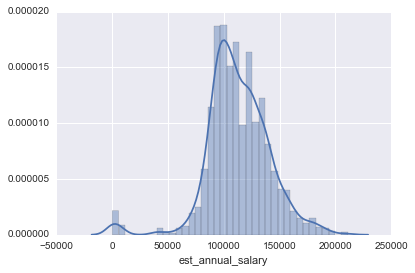

In [144]:
sns.distplot(y);

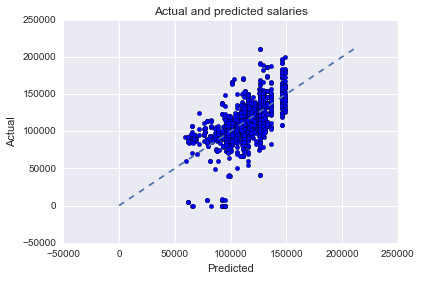

In [135]:
plt.scatter(predicted, y);
plt.plot([min(y), max(y)], [min(y), max(y)], '--');
plt.title('Actual and predicted salaries');
plt.xlabel('Predicted');
plt.ylabel('Actual');

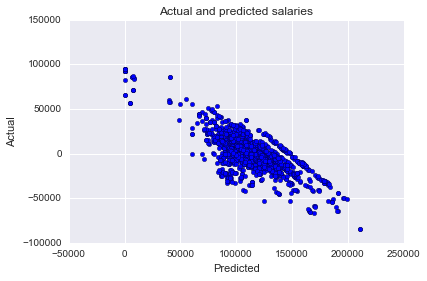

In [141]:
plt.scatter(y, predicted-y);
plt.plot(0,0, '--');
plt.title('Actual and predicted salaries');
plt.xlabel('Predicted');
plt.ylabel('Actual');